In [ ]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict,Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import string
import re
import plotly.express as px
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, Concatenate, LeakyReLU, GRU, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import GlobalMaxPool1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model


!pip install --upgrade plotly

import nltk
nltk.download('stopwords')
stop=set(stopwords.words('english'))
plt.style.use('seaborn')


import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/archive 2/Corona_NLP_train.csv',encoding='latin1')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
data["body"]=data["OriginalTweet"]
data['sentiment_summary'] = data['Sentiment']

# Checking for duplicates

In [ ]:
print("Data shape before removing duplicates: ", data.shape)

Data shape before removing duplicates:  (41157, 8)


In [ ]:
data.drop_duplicates()
print("Data shape after removing duplicates: ", data.shape)

Data shape after removing duplicates:  (41157, 8)


# Checking for Null Values

In [ ]:
data.describe()

,UserName,ScreenName
count,41157.000000,41157.000000
mean,24377.000000,69329.000000
std,11881.146851,11881.146851
min,3799.000000,48751.000000
25%,14088.000000,59040.000000
50%,24377.000000,69329.000000
75%,34666.000000,79618.000000
max,44955.000000,89907.000000


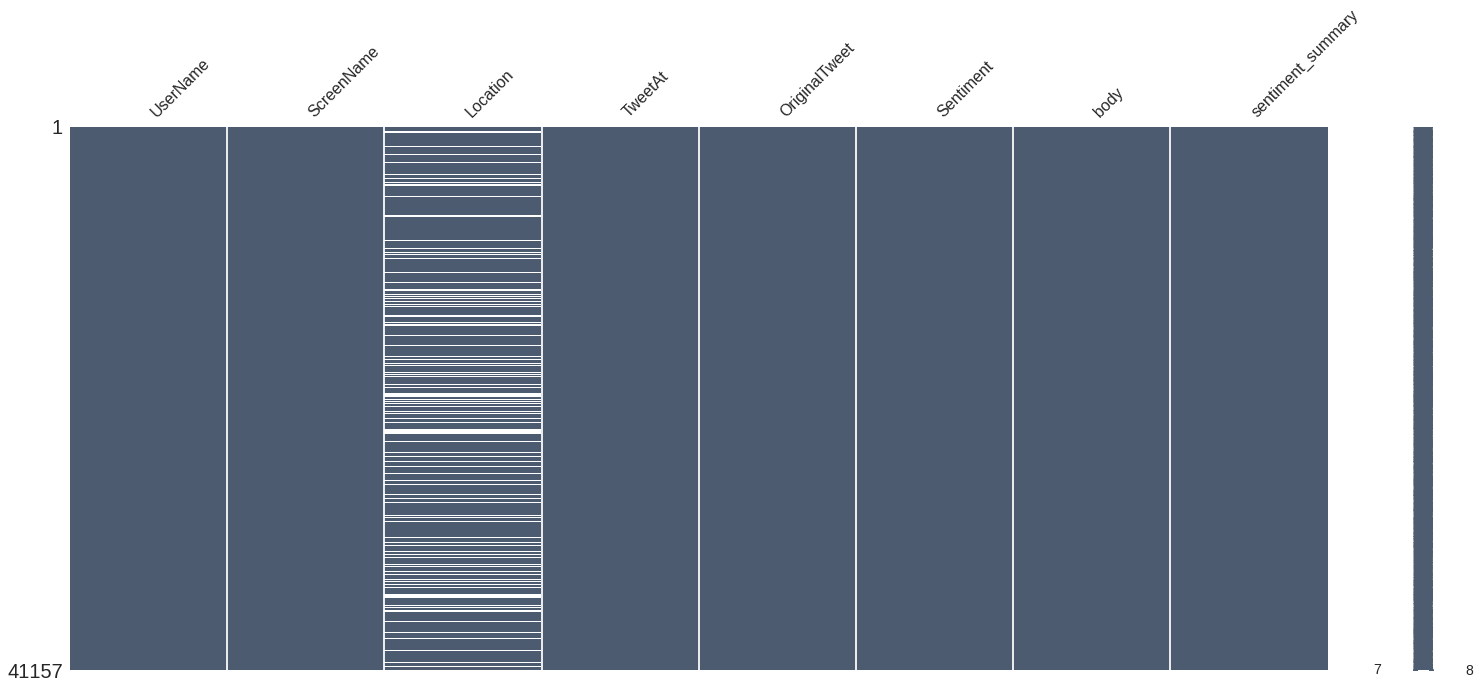

In [ ]:
#Missing data as white lines 
import missingno as msno
msno.matrix(data,color=(0.3,0.36,0.44))

In [ ]:
data = data.replace({'0':np.nan, 0:np.nan, 'Unknown':np.nan})
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,body,sentiment_summary
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"Me, ready to go at supermarket during the #COV...",Extremely Negative


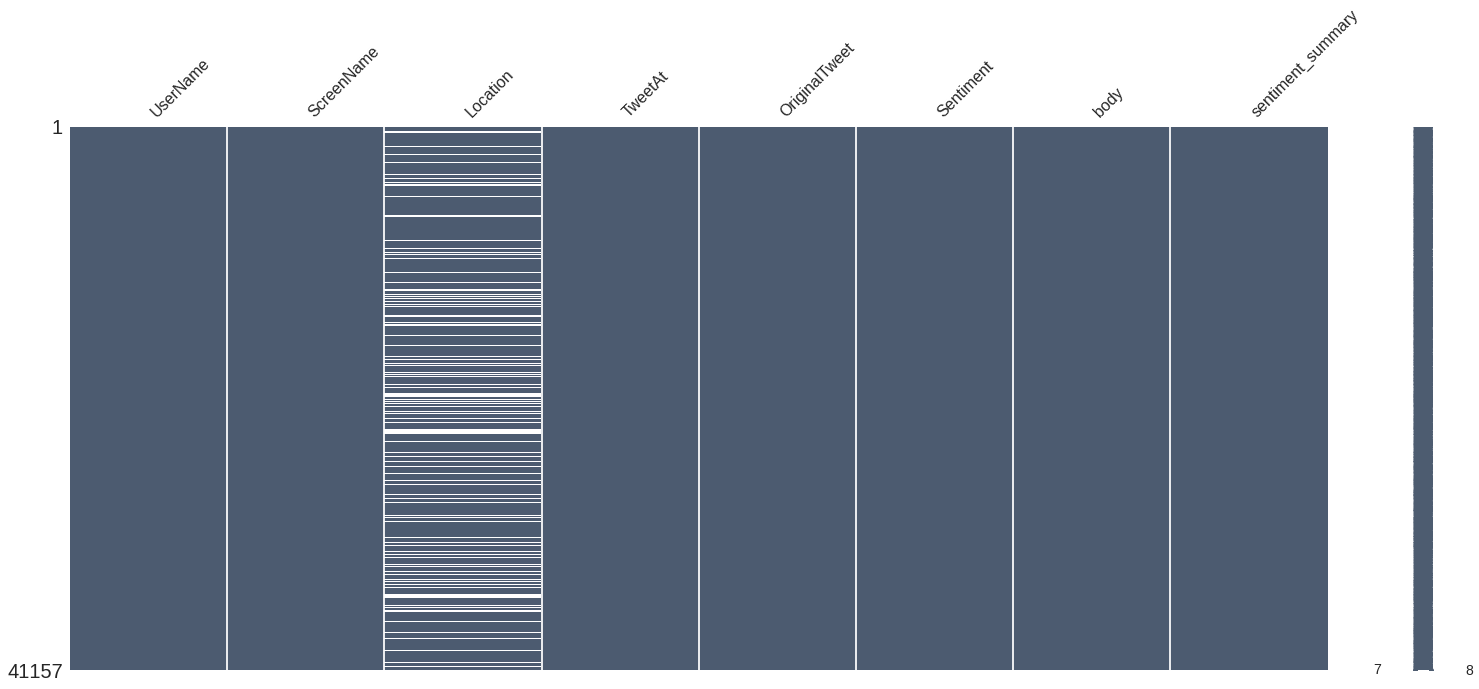

In [ ]:
#Missing data as white lines 
import missingno as msno
msno.matrix(data,color=(0.3,0.36,0.44))

In [ ]:
data.isnull().sum()

UserName                0
ScreenName              0
Location             8593
TweetAt                 0
OriginalTweet           0
Sentiment               0
body                    0
sentiment_summary       0
dtype: int64

In [ ]:
print(data.sentiment_summary.unique())
print(data.sentiment_summary.value_counts())

['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: sentiment_summary, dtype: int64


In [ ]:
class_data = data.groupby('sentiment_summary').count()['body'].reset_index().sort_values(by='body',ascending=False)
class_data

,sentiment_summary,body
4,Positive,11422
2,Negative,9917
3,Neutral,7713
1,Extremely Positive,6624
0,Extremely Negative,5481


In [ ]:
def convert_Sentiment(sentiment):
    if sentiment == "Extremely Positive":
        return "positive"
    elif sentiment == "Extremely Negative":
        return "negative"
    elif sentiment == "Positive":
        return "positive"
    elif sentiment == "Negative":
        return "negative"
    else:
        return "neutral"

data.sentiment_summary = data.sentiment_summary.apply(lambda x : convert_Sentiment(x))

#  Number of characters

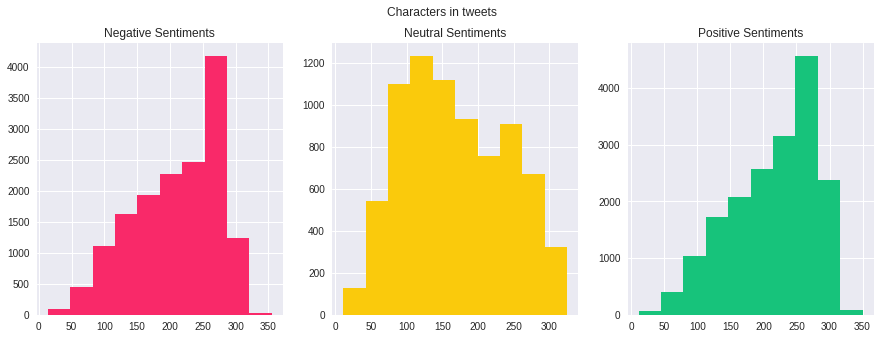

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=data[data['sentiment_summary']=="negative"]['body'].str.len()
ax1.hist(tweet_len,color='#F92969')
ax1.set_title('Negative Sentiments')

tweet_len=data[data['sentiment_summary']=="neutral"]['body'].str.len()
ax2.hist(tweet_len,color='#FACA0C')
ax2.set_title('Neutral Sentiments')

tweet_len=data[data['sentiment_summary']=="positive"]['body'].str.len()
ax3.hist(tweet_len,color='#17C37B')
ax3.set_title('Positive Sentiments')

fig.suptitle('Characters in tweets')
plt.show()

# Number of words in a tweet

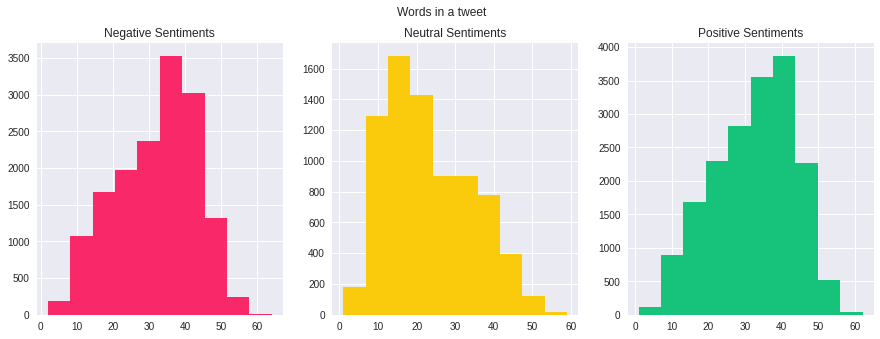

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=data[data['sentiment_summary']=="neutral"]['body'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='#FACA0C')
ax2.set_title('Neutral Sentiments')

tweet_len=data[data['sentiment_summary']=="negative"]['body'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='#F92969')
ax1.set_title('Negative Sentiments')

tweet_len=data[data['sentiment_summary']=="positive"]['body'].str.split().map(lambda x: len(x))
ax3.hist(tweet_len,color='#17C37B')
ax3.set_title('Positive Sentiments')

fig.suptitle('Words in a tweet')
plt.show()


# Average word length in a tweet

Text(0.5, 0.98, 'Average word length in each tweet')

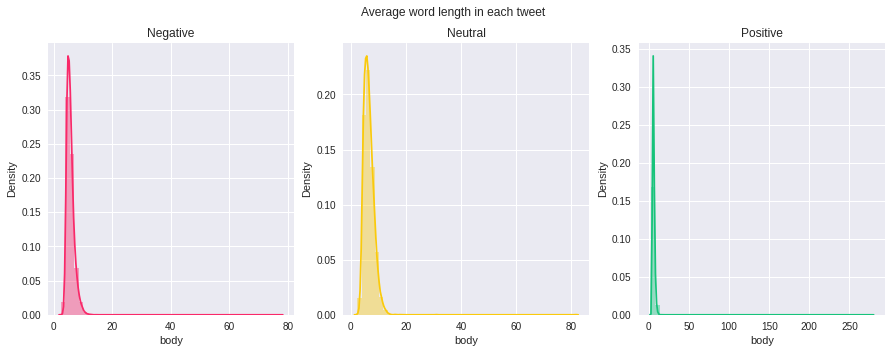

In [ ]:
fig,(ax1,ax2, ax3)=plt.subplots(1,3,figsize=(15,5))

word=data[data['sentiment_summary']=="positive"]['body'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax3,color='#17C37B')
ax3.set_title('Positive')


word=data[data['sentiment_summary']=="negative"]['body'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='#F92969')
ax1.set_title('Negative')

word=data[data['sentiment_summary']=="neutral"]['body'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='#FACA0C')
ax2.set_title('Neutral')


fig.suptitle('Average word length in each tweet')

# Common Stopwords in the tweets

In [ ]:
def create_corpus(target):
    corpus=[]
    
    for x in data[data['sentiment_summary']==target ]['body'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [ ]:
np.array(stop)

array({'after', 'most', 'll', 'itself', 'haven', 'once', 'o', 'to', 'my', 'who', "you'll", 'are', "hadn't", 'by', 'over', 'these', 'this', 'i', 'herself', 'mightn', 'there', "didn't", 'myself', 'them', 'y', 'out', 'your', 'about', "wasn't", 'other', 'further', 'me', 'down', 'she', 'such', 'their', 'or', 'each', 'few', 'off', 'themselves', 'is', 'through', 'so', 'a', 'against', 'only', 'd', 'any', 'do', 'own', "that'll", 'doing', 'theirs', 'am', 'too', 'of', 'ain', 'we', "aren't", 'can', 'just', 'during', 'very', 'but', 'from', "wouldn't", 'at', 'shouldn', 'no', 'the', 'himself', 'him', "hasn't", 'wouldn', 'on', 'its', "needn't", 'because', 'ourselves', 'an', "you'd", "don't", 'ma', "mightn't", "weren't", "shan't", 've', 'aren', 'm', "mustn't", 'yourselves', 'not', 'be', 'those', "it's", 'into', 'his', 'as', 'until', 'they', 'in', 'having', 's', 'you', 't', 'has', 'if', 'nor', 'have', 'whom', 'wasn', 'some', 'when', "doesn't", 'with', 'both', 'being', 'same', 'he', 'where', 'should', 't

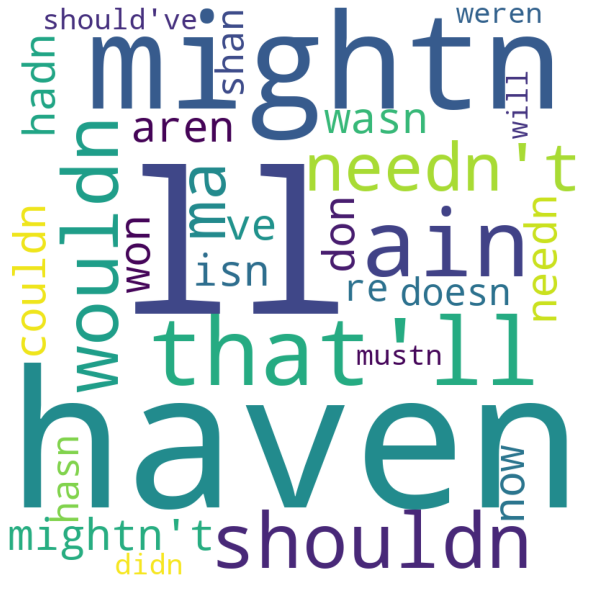

In [ ]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  

for val in stop: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = "white") 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

<BarContainer object of 10 artists>

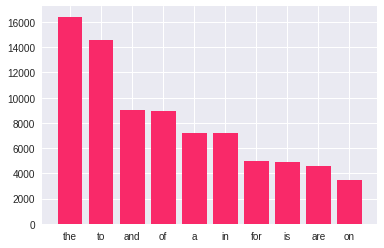

In [ ]:
corpus=create_corpus("negative")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
          
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#F92969')

<BarContainer object of 10 artists>

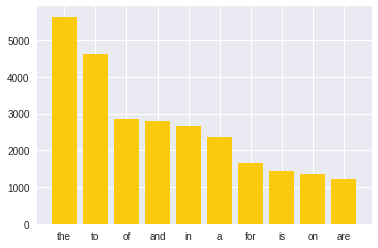

In [ ]:
corpus=create_corpus("neutral")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
               
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#FACA0C')

<BarContainer object of 10 artists>

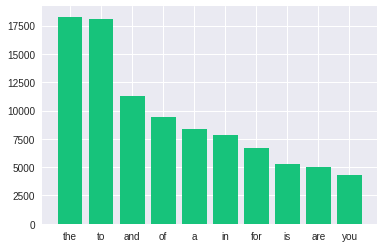

In [ ]:
corpus=create_corpus("positive")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1     
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#17C37B')

# Punctuations

<BarContainer object of 25 artists>

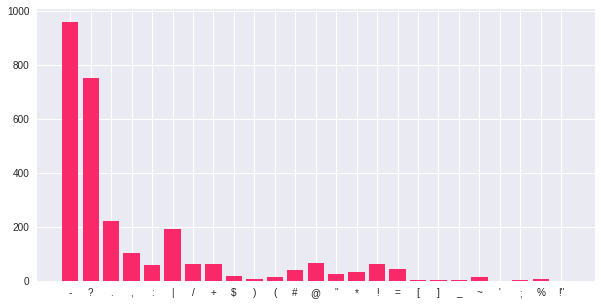

In [ ]:
plt.figure(figsize=(10,5))
corpus=create_corpus("negative")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
                
x,y=zip(*dic.items())
plt.bar(x,y, color='#F92969')

<BarContainer object of 23 artists>

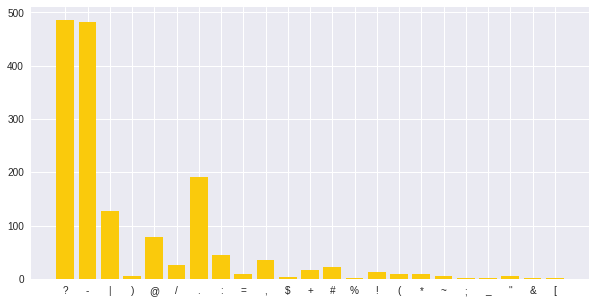

In [ ]:
plt.figure(figsize=(10,5))
corpus=create_corpus("neutral")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1

        
x,y=zip(*dic.items())
plt.bar(x,y,color='#FACA0C')

<BarContainer object of 27 artists>

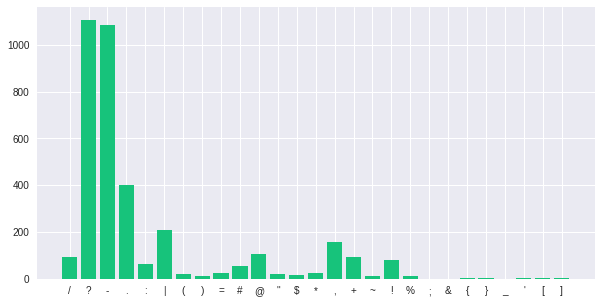

In [ ]:
plt.figure(figsize=(10,5))
corpus=create_corpus("positive")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='#17C37B')

# Common Words

In [ ]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

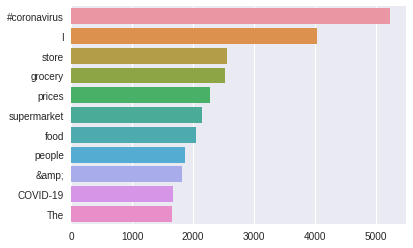

In [ ]:
sns.barplot(x=y,y=x)

# Hashtags

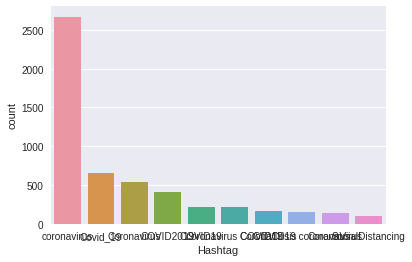

In [ ]:
def find_hash(body):
    line=re.findall(r'(?<=#)\w+',body)
    return " ".join(line)
data['hash']=data['body'].apply(lambda x:find_hash(x))
temp=data['hash'].value_counts()[:][1:11]
temp= temp.to_frame().reset_index().rename(columns={'index':'Hashtag','hash':'count'})
sns.barplot(x="Hashtag",y="count", data = temp)

# Mentions

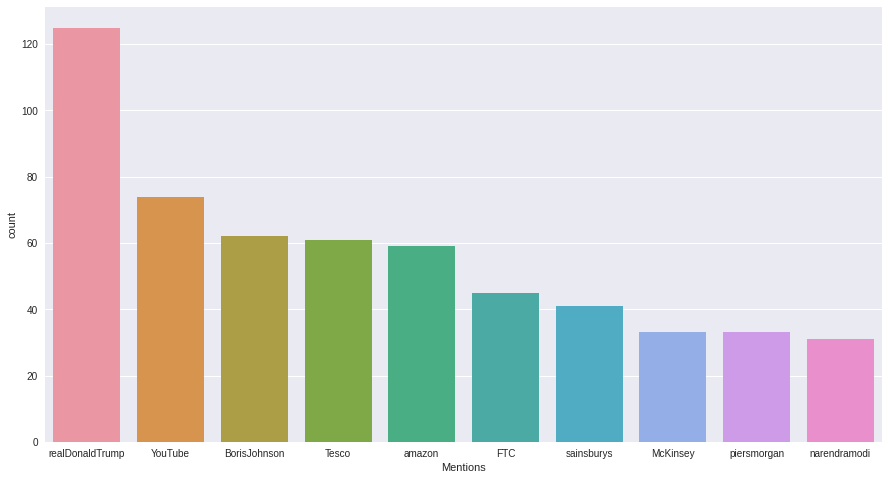

In [ ]:
def mentions(body):
    line=re.findall(r'(?<=@)\w+',body)
    return " ".join(line)
data['mentions']=data['body'].apply(lambda x:mentions(x))

temp=data['mentions'].value_counts()[:][1:11]
temp =temp.to_frame().reset_index().rename(columns={'index':'Mentions','mentions':'count'})

fig_dims = (15, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x="Mentions",y="count", data = temp, ax=ax)

In [ ]:
b = data['mentions'].value_counts()[:][1:11].index.tolist()
a = data['mentions'].value_counts()[:][1:11].tolist()
row = pd.DataFrame({'scenario' : []})
row["scenario"] = b
row["Percentage"] = a
fig = px.treemap(row, path= ["scenario"], values="Percentage",title='Tree of Mentions')
fig.show()

# Pre-processing

In [ ]:
#Remove Urls and HTML links
def remove_urls(body):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', body)
data['body_new']=data['body'].apply(lambda x:remove_urls(x))

def remove_html(body):
    html=re.compile(r'<.*?>')
    return html.sub(r'',body)
data['body']=data['body_new'].apply(lambda x:remove_html(x))

In [ ]:
# Lower casing
def lower(body):
    low_body= body.lower()
    return low_body
data['body_new']=data['body'].apply(lambda x:lower(x))


# Number removal
def remove_num(body):
    remove= re.sub(r'\d+', '', body)
    return remove
data['body']=data['body_new'].apply(lambda x:remove_num(x))

In [ ]:
#Remove stopwords & Punctuations
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def punct_remove(body):
    punct = re.sub(r"[^\w\s\d]","", body)
    return punct
data['body_new']=data['body'].apply(lambda x:punct_remove(x))



def remove_stopwords(body):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(body).split() if word not in STOPWORDS])
data['body']=data['body_new'].apply(lambda x:remove_stopwords(x))

In [ ]:
#Remove mentions and hashtags
def remove_mention(x):
    body=re.sub(r'@\w+','',x)
    return body
data['body_new']=data['body'].apply(lambda x:remove_mention(x))
def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text
data['body']=data['body_new'].apply(lambda x:remove_hash(x))

In [ ]:
#Remove extra white space left while removing stuff
def remove_space(body):
    space_remove = re.sub(r"\s+"," ",body).strip()
    return space_remove
data['body_new']=data['body'].apply(lambda x:remove_space(x))

data = data.drop(columns=['body_new'])

# Wordclouds

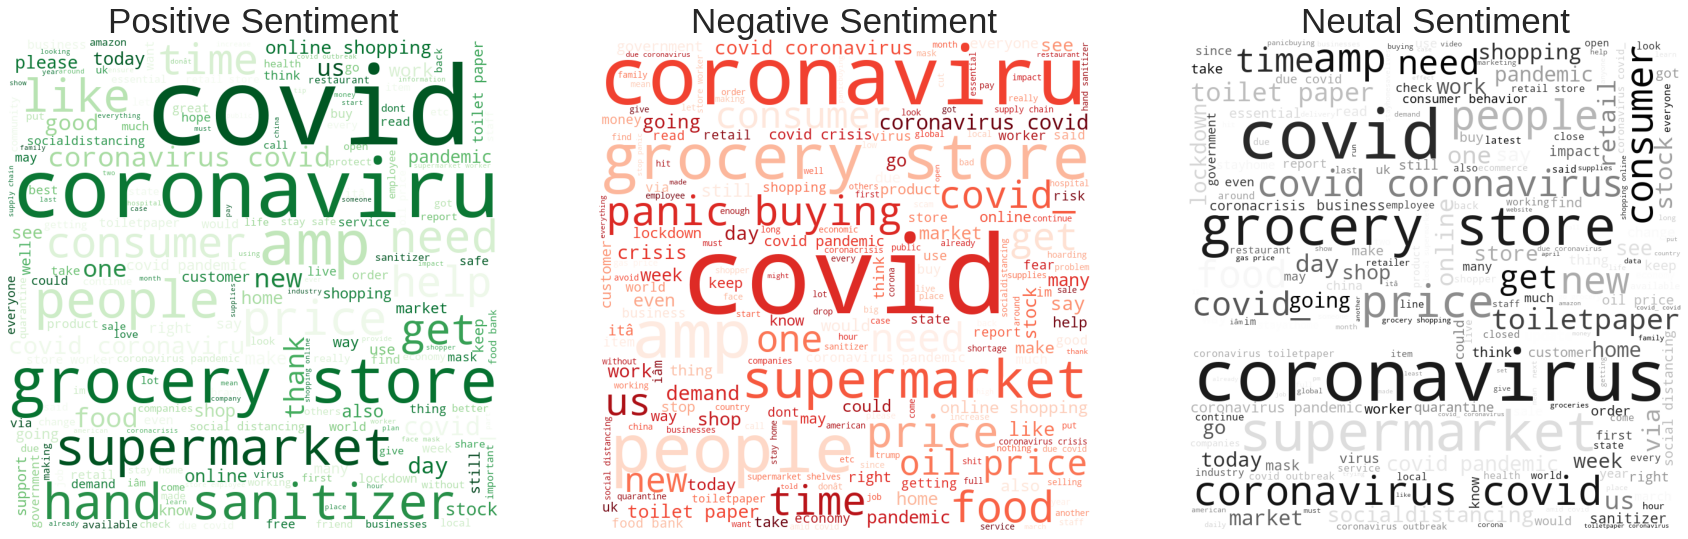

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])

data_pos = data[data["sentiment_summary"]=="positive"]
data_neg = data[data["sentiment_summary"]=="negative"]
data_neu = data[data["sentiment_summary"]=="neutral"]

comment_words = '' 
stopwords = set(STOPWORDS) 

for val in data_pos.body: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
   

wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Greens",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive Sentiment',fontsize=35);

comment_words = ''

for val in data_neg.body: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "




wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Reds",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)  
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Sentiment',fontsize=35);



comment_words = ''
for val in data_neu.body: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud3 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Greys",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutal Sentiment',fontsize=35);

In [ ]:
del data_pos
del data_neg
del data_neu

 # N-grams

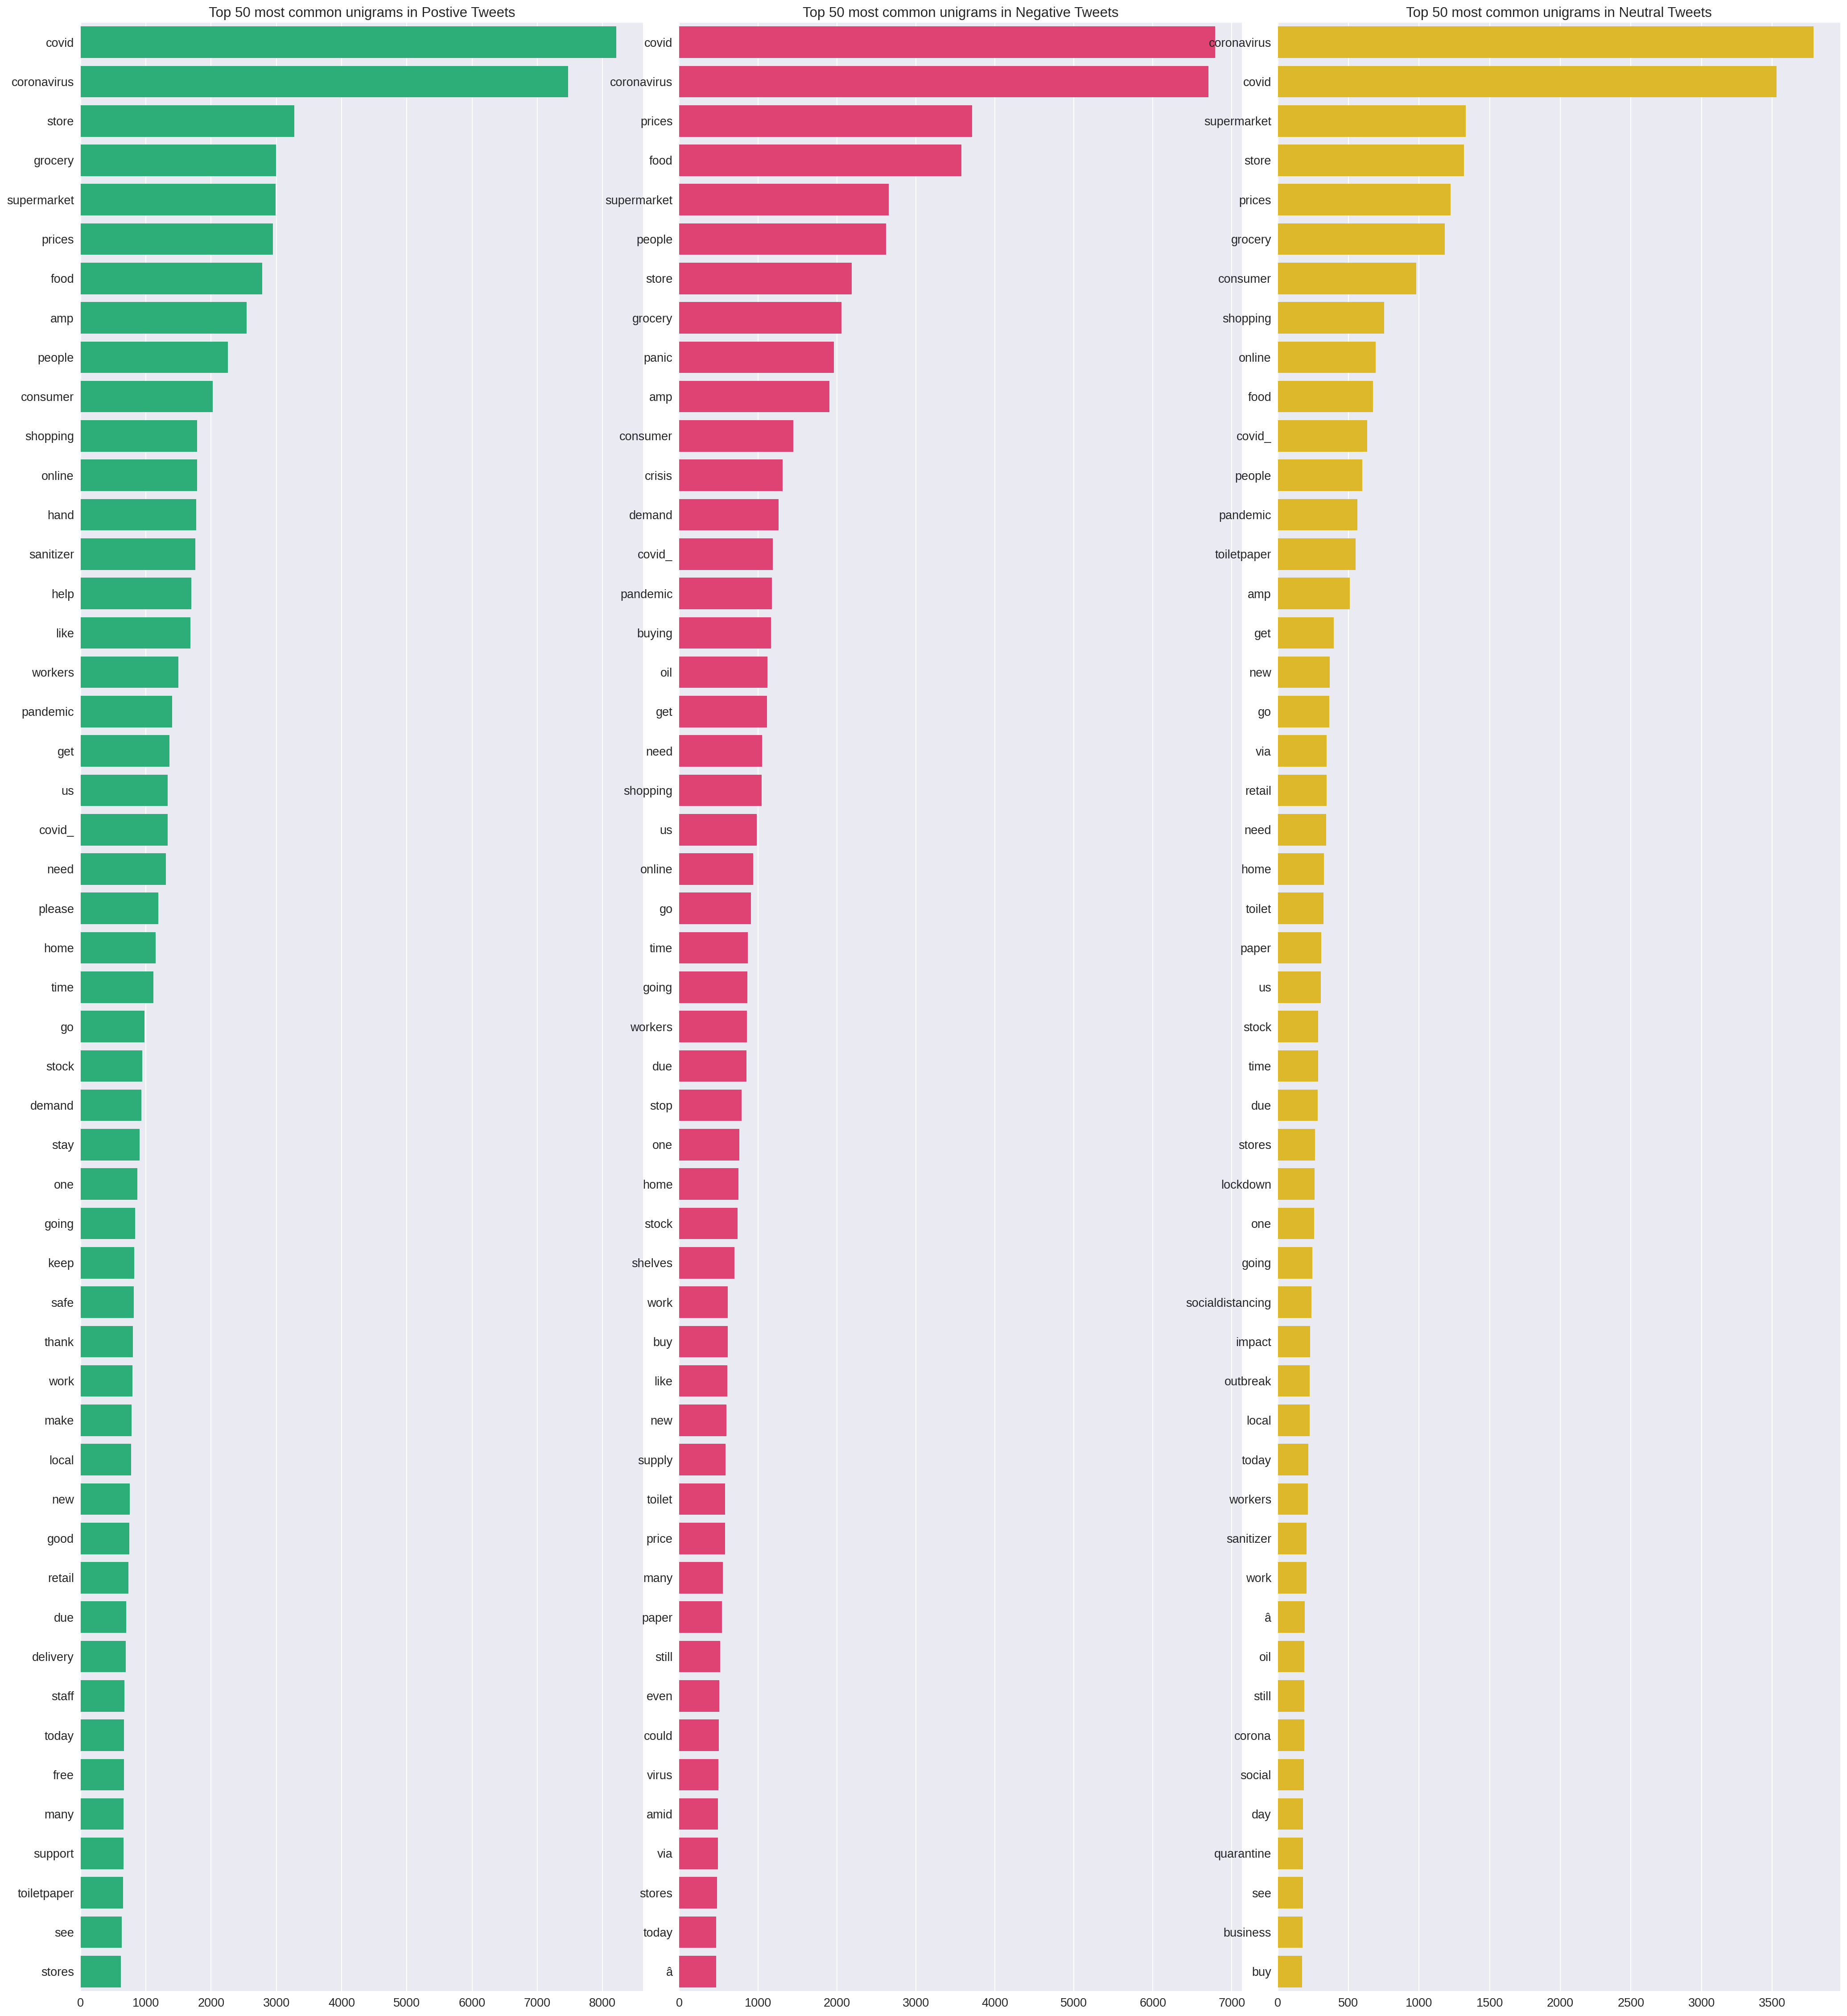

In [ ]:
# Define functions
def generate_ngrams(body, n_gram=1):
    token = [token for token in body.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 50



positive= data["sentiment_summary"]== "positive"
negative= data["sentiment_summary"]== "negative"
neutral= data["sentiment_summary"]== "neutral"

positive_unigrams = defaultdict(int)
neutral_unigrams = defaultdict(int)
negative_unigrams = defaultdict(int)

# Unigrams
for tweet in data[positive]['body']:
    for word in generate_ngrams(tweet):
        positive_unigrams[word] += 1
        
for tweet in data[negative]['body']:
    for word in generate_ngrams(tweet):
        negative_unigrams[word] += 1
        
for tweet in data[neutral]['body']:
    for word in generate_ngrams(tweet):
        neutral_unigrams[word] += 1        
        
data_positive_unigrams = pd.DataFrame(sorted(positive_unigrams.items(), key=lambda x: x[1])[::-1])
data_negative_unigrams = pd.DataFrame(sorted(negative_unigrams.items(), key=lambda x: x[1])[::-1])
data_neutral_unigrams = pd.DataFrame(sorted(neutral_unigrams.items(), key=lambda x: x[1])[::-1])


fig, axes = plt.subplots(ncols=3, figsize=(27, 30), dpi=150)
plt.tight_layout()

sns.barplot(y=data_positive_unigrams[0].values[:N], x=data_positive_unigrams[1].values[:N], ax=axes[0], color='#17C37B')
sns.barplot(y=data_negative_unigrams[0].values[:N], x=data_negative_unigrams[1].values[:N], ax=axes[1], color='#F92969')
sns.barplot(y=data_neutral_unigrams[0].values[:N], x=data_neutral_unigrams[1].values[:N], ax=axes[2], color='#FACA0C')


for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Postive Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Negative Tweets', fontsize=15)
axes[2].set_title(f'Top {N} most common unigrams in Neutral Tweets', fontsize=15)

plt.show()

# Bi-grams

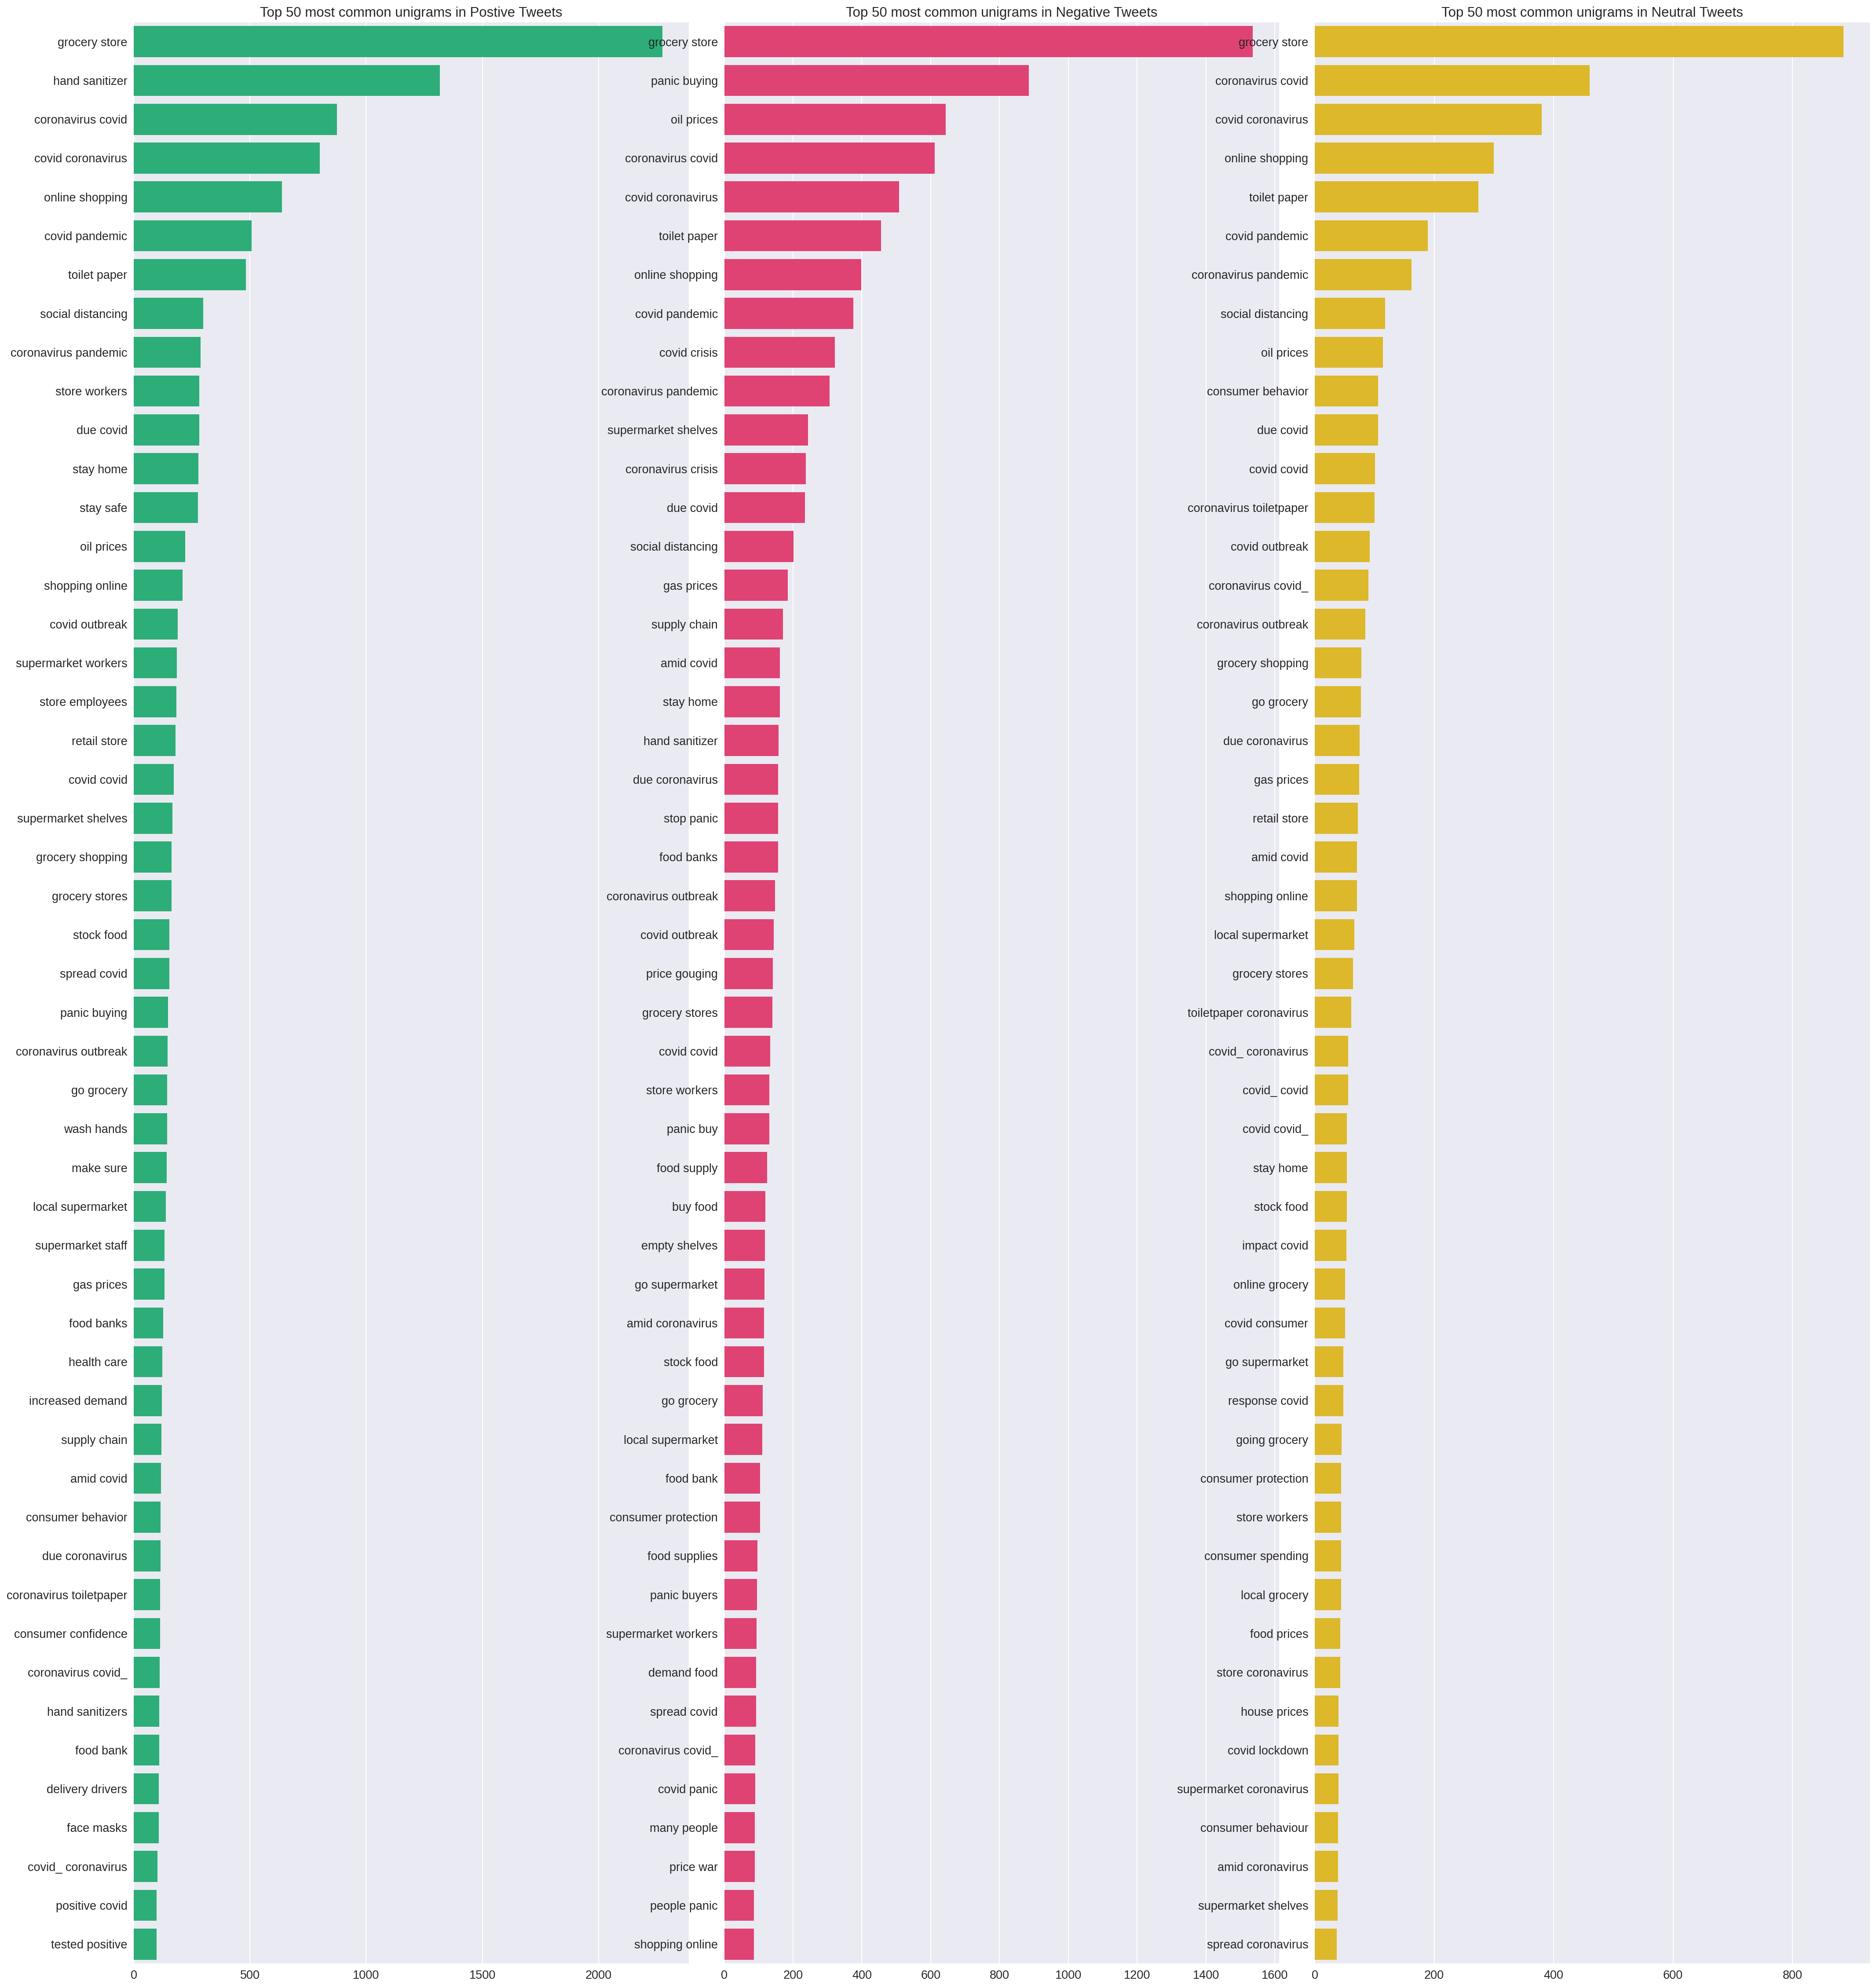

In [ ]:
positive_bigrams = defaultdict(int)
neutral_bigrams = defaultdict(int)
negative_bigrams = defaultdict(int)

# Unigrams
for tweet in data[positive]['body']:
    for word in generate_ngrams(tweet, n_gram=2):
        positive_bigrams[word] += 1
        
for tweet in data[negative]['body']:
    for word in generate_ngrams(tweet, n_gram=2):
        negative_bigrams[word] += 1
        
for tweet in data[neutral]['body']:
    for word in generate_ngrams(tweet, n_gram=2):
        neutral_bigrams[word] += 1        
        
data_positive_bigrams = pd.DataFrame(sorted(positive_bigrams.items(), key=lambda x: x[1])[::-1])
data_negative_bigrams = pd.DataFrame(sorted(negative_bigrams.items(), key=lambda x: x[1])[::-1])
data_neutral_bigrams = pd.DataFrame(sorted(neutral_bigrams.items(), key=lambda x: x[1])[::-1])


fig, axes = plt.subplots(ncols=3, figsize=(27, 30), dpi=150)
plt.tight_layout()

sns.barplot(y=data_positive_bigrams[0].values[:N], x=data_positive_bigrams[1].values[:N], ax=axes[0], color='#17C37B')
sns.barplot(y=data_negative_bigrams[0].values[:N], x=data_negative_bigrams[1].values[:N], ax=axes[1], color='#F92969')
sns.barplot(y=data_neutral_bigrams[0].values[:N], x=data_neutral_bigrams[1].values[:N], ax=axes[2], color='#FACA0C')


for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Postive Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Negative Tweets', fontsize=15)
axes[2].set_title(f'Top {N} most common unigrams in Neutral Tweets', fontsize=15)

plt.show()

# Tri-grams

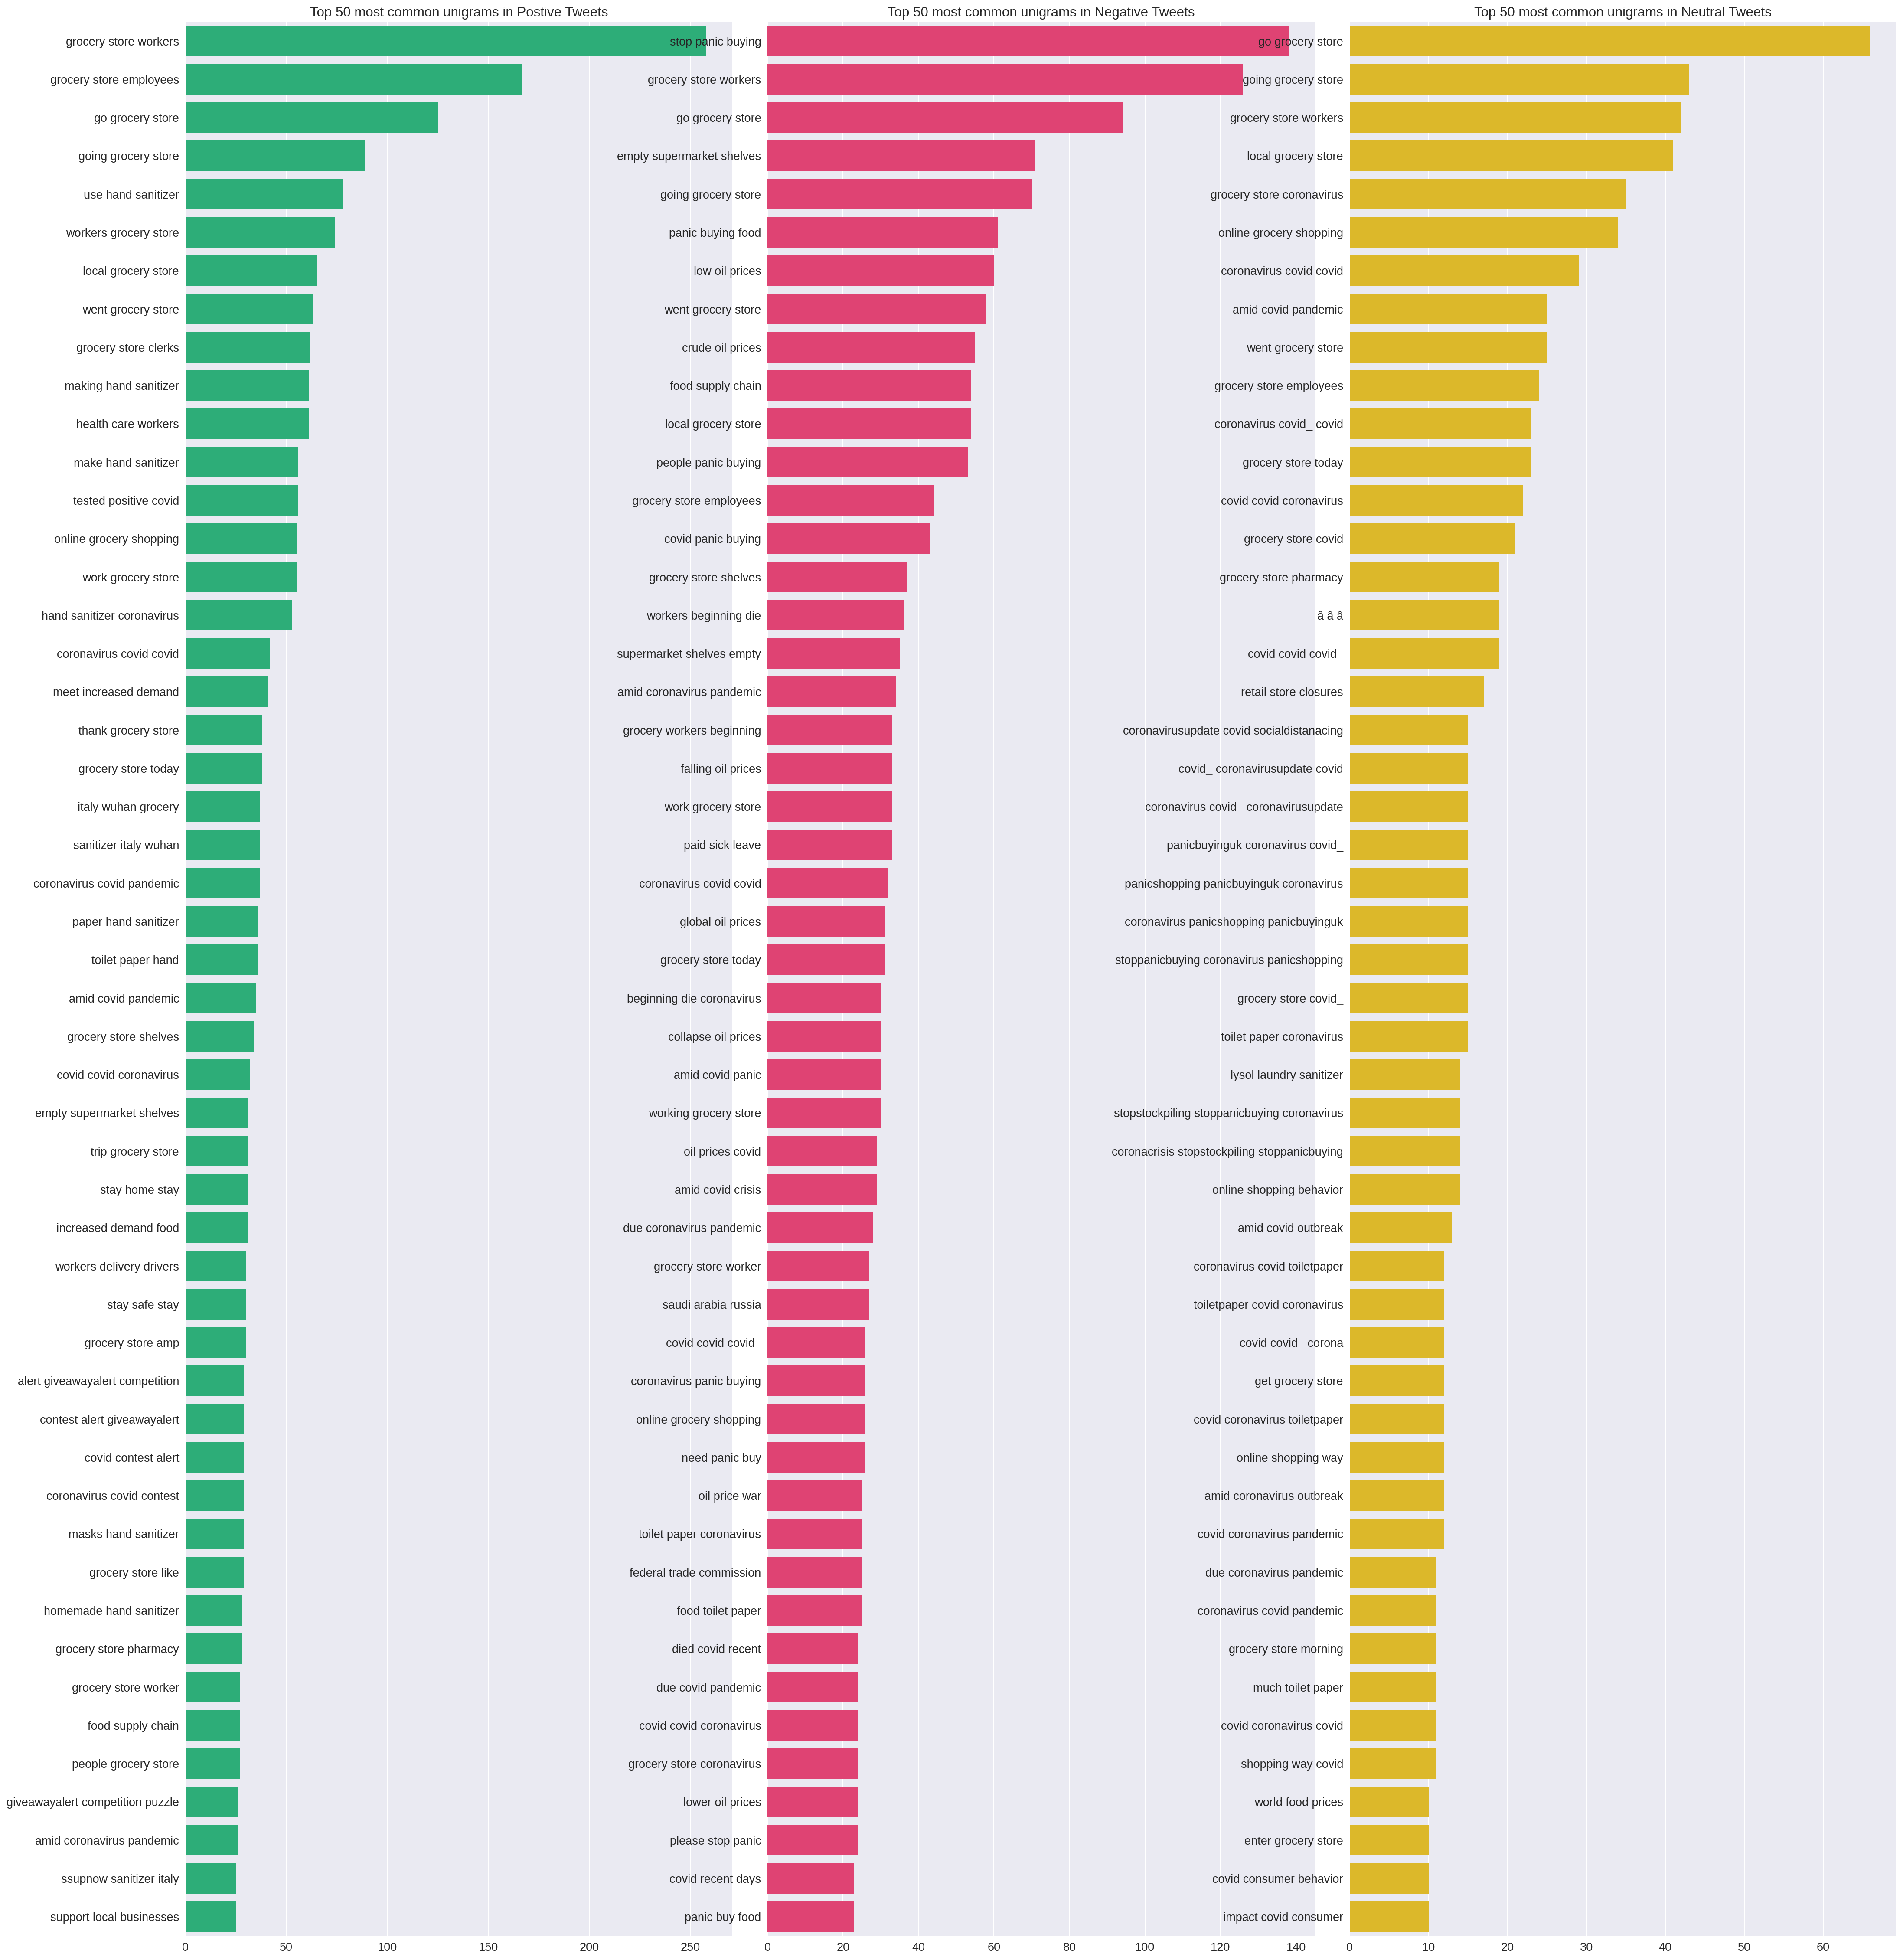

In [ ]:
positive_trigrams = defaultdict(int)
neutral_trigrams = defaultdict(int)
negative_trigrams = defaultdict(int)

# Unigrams
for tweet in data[positive]['body']:
    for word in generate_ngrams(tweet, n_gram=3):
        positive_trigrams[word] += 1
        
for tweet in data[negative]['body']:
    for word in generate_ngrams(tweet, n_gram=3):
        negative_trigrams[word] += 1
        
for tweet in data[neutral]['body']:
    for word in generate_ngrams(tweet, n_gram=3):
        neutral_trigrams[word] += 1        
        
data_positive_trigrams = pd.DataFrame(sorted(positive_trigrams.items(), key=lambda x: x[1])[::-1])
data_negative_trigrams = pd.DataFrame(sorted(negative_trigrams.items(), key=lambda x: x[1])[::-1])
data_neutral_trigrams = pd.DataFrame(sorted(neutral_trigrams.items(), key=lambda x: x[1])[::-1])


fig, axes = plt.subplots(ncols=3, figsize=(27, 30), dpi=150)
plt.tight_layout()

sns.barplot(y=data_positive_trigrams[0].values[:N], x=data_positive_trigrams[1].values[:N], ax=axes[0], color='#17C37B')
sns.barplot(y=data_negative_trigrams[0].values[:N], x=data_negative_trigrams[1].values[:N], ax=axes[1], color='#F92969')
sns.barplot(y=data_neutral_trigrams[0].values[:N], x=data_neutral_trigrams[1].values[:N], ax=axes[2], color='#FACA0C')


for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Postive Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Negative Tweets', fontsize=15)
axes[2].set_title(f'Top {N} most common unigrams in Neutral Tweets', fontsize=15)

plt.show()

# LSTM Model

In [ ]:
# Convert sentiment into Positive = 2 , Neutral = 1 , Negative =  0
def convert_Sentiment(sentiment):
    if sentiment == "positive":
        return 2
    elif sentiment == "negative":
        return 0
    else:
        return 1

data.sentiment_summary = data.sentiment_summary.apply(lambda x : convert_Sentiment(x))


In [ ]:
data['sentiment_summary'].value_counts()

2    18046
0    15398
1     7713
Name: sentiment_summary, dtype: int64

In [ ]:
X = data['body']
y = data['sentiment_summary']

# Split data into train , test
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
print('Shape of X_train : ' , X_train.shape)
print('Shape of y_train : ', y_train.shape)
print('Shape of X_test : ', X_test.shape)
print('Shape of y_test : ',y_test.shape)

Shape of X_train :  (32925,)
Shape of y_train :  (32925,)
Shape of X_test :  (8232,)
Shape of y_test :  (8232,)


In [ ]:
# Convert y to categorical 
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test  = to_categorical(y_test, 3)

In [ ]:
# Tokenize Texts
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# convert tokenized texts into same padding size
maxlen = 200
embed_size = 128 
X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test_final = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [ ]:
# Create Model  
inp = Input(shape=(maxlen, )) 
x   =  Embedding(max_features, embed_size)(inp)
x   =  LSTM(60, return_sequences=True,name='lstm_layer')(x)
x   =  GlobalMaxPool1D()(x)
# x   =  Dense(128, activation="relu")(x)
# x   =  Dropout(0.2)(x)
x   =  Dense(64, activation="relu")(x)
x   =  Dropout(0.2)(x)
x   =  Dense(3, activation="softmax")(x)

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 128)          2560000   
                                                                 
 lstm_layer (LSTM)           (None, 200, 60)           45360     
                                                                 
 global_max_pooling1d (Globa  (None, 60)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                3904      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                             

In [ ]:
call_back = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
model.fit(X_train_final,y_train, epochs=2, callbacks= [call_back], validation_data=(X_test_final,y_test))

Epoch 1/2
1029/1029 [==============================] - 166s 159ms/step - loss: 0.6314 - accuracy: 0.7379 - val_loss: 0.4679 - val_accuracy: 0.8335
Epoch 2/2
1029/1029 [==============================] - 164s 159ms/step - loss: 0.3494 - accuracy: 0.8861 - val_loss: 0.4611 - val_accuracy: 0.8404


In [ ]:
# Evaluate
model.evaluate(X_test_final,y_test)

258/258 [==============================] - 8s 30ms/step - loss: 0.4611 - accuracy: 0.8404


[0.46107247471809387, 0.840378999710083]

In [ ]:
# Predict test
lstm_pred = np.round(model.predict(X_test_final))

In [ ]:
# Precision , Recall , F1-score
cr = classification_report(y_test,lstm_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      3080
           1       0.83      0.72      0.77      1526
           2       0.86      0.86      0.86      3626

   micro avg       0.86      0.82      0.84      8232
   macro avg       0.85      0.80      0.82      8232
weighted avg       0.86      0.82      0.84      8232
 samples avg       0.82      0.82      0.82      8232



# Bert

In [ ]:
data['body'].head()

0                         menyrbie phil_gahan chrisitv
1    advice talk neighbours family exchange phone n...
2    coronavirus australia woolworths give elderly ...
3    food stock one empty please dont panic enough ...
4    ready go supermarket covid outbreak im paranoi...
Name: body, dtype: object

In [ ]:
len(X_test_final)

8232